In [35]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error

In [36]:
df = pd.read_csv("DBtrainrides_final_result.csv")

In [37]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../utils')))  # Add the parent directory to the path

from utils.utils import fill_missing_times, normalize_dates, ordinal_scaling

In [38]:
message_order = ['No message', 'Information', 'Bauarbeiten', 'Störung', 'Großstörung']
df = ordinal_scaling(df, "transformed_info_message", "label_info_encoded", message_order)
df = normalize_dates(df)

df

In [39]:
df.to_csv("DBtrainrides_normalised.csv", index=False)

In [40]:
# df = pd.read_csv("DBtrainrides_normalised.csv")

# Linear Regression

In [41]:
linear_regressor = LinearRegression()

In [42]:
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test)

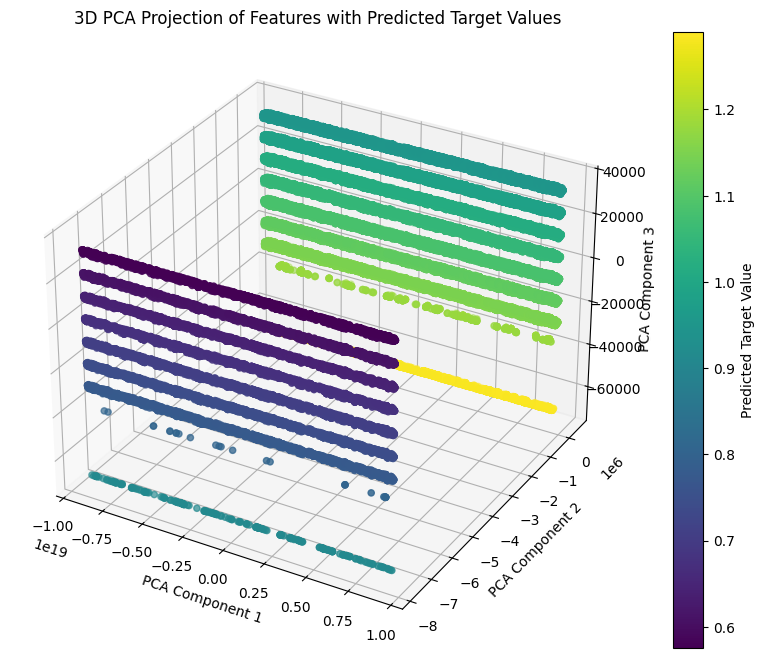

In [43]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
# Apply PCA to reduce the dimensionality to 3 dimensions
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(X_test)

# Create a 3D scatter plot of the reduced features, colored by predicted target values
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=y_pred, cmap='viridis')
fig.colorbar(scatter, label='Predicted Target Value')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('3D PCA Projection of Features with Predicted Target Values')
plt.show()


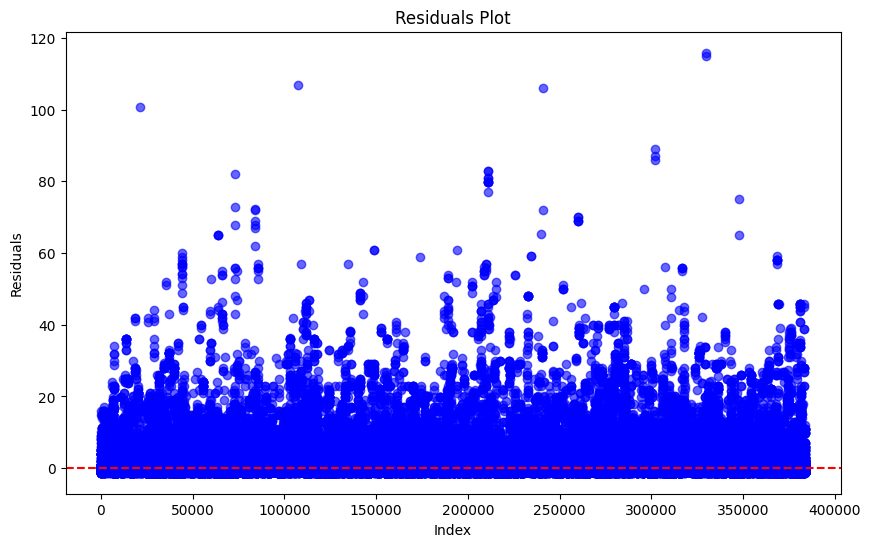

In [44]:
# Assuming you have actual target values (cleaned_target_test)
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, c='b', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [45]:
# Evaluate the model
mse = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mse)
print("R^2 Score:", r2)

Mean Absolute Error: 1.5032701779947442
R^2 Score: 0.0009400824149605747


In [46]:
param_space = {'copy_X': [True,False], 
               'fit_intercept': [True,False], 
               'n_jobs': [1,5,10,15,None], 
               'positive': [True,False]}

In [47]:
grid_search_lr = GridSearchCV(linear_regressor, param_space, cv=5)
grid_search_lr.fit(X_train, y_train) 

/root/.virtualenvs/DM-Project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/root/.virtualenvs/DM-Project/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/root/.virtualenvs/DM-Project/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/root/.virtualenvs/DM-Project/lib/python3.10/site-packages/sklearn/linear_model/_base.py", line 647, in fit
    

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': [1, 5, 10, 15, None],
                         'positive': [True, False]})

In [48]:
results = pd.DataFrame(grid_search_lr.cv_results_)
cv_params = results["params"]
cv_mean_test_score = results["mean_test_score"]
param_test_scores = []

In [49]:
for key in cv_params.keys():
    param = str(cv_params[key])
    score = float(cv_mean_test_score[key])
    target = (param, score)
    param_test_scores.append(target)

In [50]:
param_test_scores = sorted(param_test_scores, key=lambda x: x[1], reverse=True)

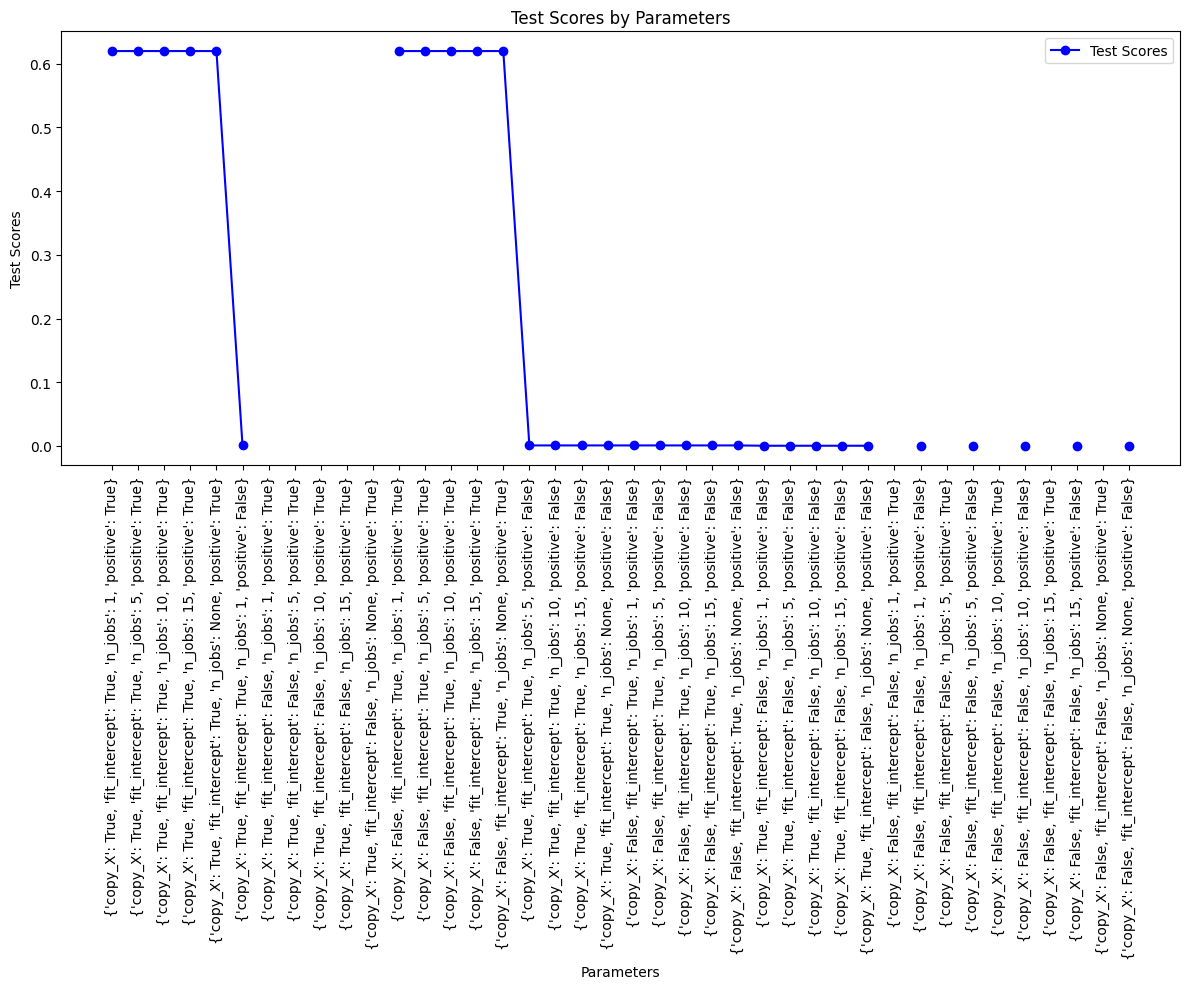

In [51]:
plt.figure(figsize=(12, 10))
plt.plot(
    [param for param, _ in param_test_scores],  # x-axis: parameters
    [score for _, score in param_test_scores],  # y-axis: test_scores
    marker='o', linestyle='-', color='b', label='Test Scores'
)

# Add labels and title
plt.xlabel('Parameters')
plt.ylabel('Test Scores')
plt.title('Test Scores by Parameters')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to fit rotated labels
plt.show()

In [52]:
linear_regressor = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, positive=True)
linear_regressor.fit(X_train, y_train)

LinearRegression(n_jobs=1, positive=True)

In [53]:
y_pred = linear_regressor.predict(X_test)
mae = mean_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred=y_pred, y_true=y_test)
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 0.7238454031206353
R2 Score: 0.5800884366410537
